# 🌌 Master Notebook – Pipeline Spectroscopie DR5

## Objectif du pipeline

- Ce notebook télécharge, prépare et journalise des spectres .fits.gz de LAMOST DR5 pour entraîner un modèle de classification.
- Le DatasetBuilder garantit qu'aucun spectre ne sera jamais réutilisé en s'appuyant sur un log de fichiers déjà traités.
- Ce pipeline permet d’ajouter progressivement des spectres au jeu d’entraînement, en assurant qu’aucun spectre ne soit traité deux fois. Chaque exécution sélectionne un nouveau lot, l’entraîne, puis marque les spectres comme utilisés.


#

## Étape 0 : SETUP & IMPORTS

In [1]:
import os
import sys
import json
import gzip
import hashlib
import subprocess
import pandas as pd
import numpy as np
from astropy.io import fits
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

# Recherche la racine du projet en montant les dossiers
current_path = os.getcwd()  # fonctionne aussi en notebook
while not (
    os.path.isdir(os.path.join(current_path, "data")) and 
    os.path.isdir(os.path.join(current_path, "src"))
) and current_path != os.path.dirname(current_path):
    current_path = os.path.dirname(current_path)

PROJECT_ROOT = current_path
print(f"[INFO] Racine projet : {PROJECT_ROOT}")

# Configuration des chemins de données
RAW_DATA_DIR = os.path.join(PROJECT_ROOT, "data", "raw")
CATALOG_DIR = os.path.join(PROJECT_ROOT, "data", "catalog")
PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data", "processed")
NOTEBOOKS_DIR = os.path.join(PROJECT_ROOT, "notebooks")
SRC_DIR = os.path.join(PROJECT_ROOT, "src")
MODELS_DIR = os.path.join(PROJECT_ROOT, "data", "models")

# Créer le dossier des modèles s'il n'existe pas
os.makedirs(MODELS_DIR, exist_ok=True)

# Ajouter 'src' à sys.path pour permettre les imports maison
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)
    print(f"[INFO] Dossier 'src' ajouté à sys.path : {SRC_DIR}")

# Imports de tes modules maison (doivent se faire après l'ajout au sys.path)
from pipeline.preprocessor import SpectraPreprocessor
from pipeline.peak_detector import PeakDetector
from pipeline.feature_engineering import FeatureEngineer
from tools.dataset_builder import DatasetBuilder

# Utiliser les variables dans tous les notebooks
catalog_path = os.path.join(CATALOG_DIR, "dr5_v3_plan_clean.csv")
features_output_path = os.path.join(PROCESSED_DIR, "features_20250701T182122Z.csv")

# Initialisation de l'outil DatasetBuilder
builder = DatasetBuilder(raw_data_dir=RAW_DATA_DIR, catalog_dir=CATALOG_DIR)

print("\nÉtape 1 : Setup terminé. Tu es prêt à lancer ton pipeline.")

[INFO] Racine projet : c:\Users\alexb\Documents\Google_Cloud\alex_labs_google_sprint\astro_spectro_git
[INFO] Dossier 'src' ajouté à sys.path : c:\Users\alexb\Documents\Google_Cloud\alex_labs_google_sprint\astro_spectro_git\src

Étape 1 : Setup terminé. Tu es prêt à lancer ton pipeline.


#

## 1) Téléchargement des spectres
Utilisation du script ``dr5_downloader.py`` encapsulé en fonction.

Cette étape est désormais externalisée dans [01_download_spectra.ipynb](./01_download_spectra.ipynb) pour être exécutée seulement au besoin.

#

## 2) Préparation des données spectrales : Sélection du lot de spectres à traiter
- Le DatasetBuilder sélectionne un lot de nouveaux spectres jamais utilisés.
- Si tous les spectres disponibles ont déjà été utilisés, le pipeline s'arrête proprement.


In [2]:
print("\n=== ÉTAPE 2 : CRÉATION D'UN NOUVEAU LOT DE SPECTRES NON DÉJÀ UTILISÉS ===")

# Pour définir la grosseur du lot modifier la variable de batch_size= par la valeur voulu
new_batch_paths = builder.get_new_training_batch(batch_size=5000, strategy="random")

if new_batch_paths:
    print(f"\n{len(new_batch_paths)} nouveaux spectres proposés pour traitement.")
    print(f"Exemple : {new_batch_paths[0]}")
else:
    print("\nAucun nouveau spectre à traiter : le pipeline est à jour.")


=== ÉTAPE 2 : CRÉATION D'UN NOUVEAU LOT DE SPECTRES NON DÉJÀ UTILISÉS ===
--- Constitution d'un nouveau lot d'entraînement ---
  > 9550 spectres trouvés dans 'c:\Users\alexb\Documents\Google_Cloud\alex_labs_google_sprint\astro_spectro_git\data\raw'
  > 0 spectres déjà utilisés dans des entraînements précédents.
  > 9550 spectres nouveaux et disponibles pour l'entraînement.
  > Sélection d'un échantillon aléatoire de 5000 spectres.

5000 nouveaux spectres proposés pour traitement.
Exemple : B6210/spec-55862-B6210_sp01-077.fits.gz


#

## 3) parcours ce lot de spectres pour générer un CSV à partir des headers des fichiers ``.fits.gz``
C’est ce CSV qui sera ton ``master_catalog`` local, aligné exactement avec les spectres que tu vas traiter dans ce lot.

In [5]:
import os
from tools.generate_catalog_from_fits import generate_catalog_from_fits

print("\n=== ÉTAPE 3 : GÉNÉRATION DU CATALOGUE LOCAL DE HEADERS ===")

# Dossier où se trouvent tes spectres téléchargés
# (adapter si ton notebook est déplacé ailleurs)
raw_data_root = RAW_DATA_DIR

# Chemin de sortie du CSV temporaire/local
output_catalog_path = os.path.join(CATALOG_DIR, "master_catalog_temp.csv")

# Vérifier et créer le dossier si nécessaire
os.makedirs(os.path.dirname(output_catalog_path), exist_ok=True)

# Préfixer chaque chemin relatif avec le chemin complet vers data/raw
full_paths = [os.path.join(raw_data_root, path) for path in new_batch_paths]

# Appel de la fonction
generate_catalog_from_fits(full_paths, output_catalog_path)

print(f"\nCatalogue master local créé : {output_catalog_path}")


=== ÉTAPE 3 : GÉNÉRATION DU CATALOGUE LOCAL DE HEADERS ===
[OK] spec-55862-B6210_sp01-077.fits.gz ajouté au catalogue.
[OK] spec-55863-GAC_105N29_B1_sp01-126.fits.gz ajouté au catalogue.
[OK] spec-55862-B6210_sp03-067.fits.gz ajouté au catalogue.
[OK] spec-55863-GAC_105N29_B1_sp14-233.fits.gz ajouté au catalogue.
[OK] spec-55862-B6212_sp07-231.fits.gz ajouté au catalogue.
[OK] spec-55863-GAC_105N29_B1_sp09-176.fits.gz ajouté au catalogue.
[OK] spec-55863-M31_011N40_B1_sp02-028.fits.gz ajouté au catalogue.
[OK] spec-55862-B6210_sp03-242.fits.gz ajouté au catalogue.
[OK] spec-55863-GAC_105N29_B1_sp16-126.fits.gz ajouté au catalogue.
[OK] spec-55863-GAC_105N29_B1_sp06-182.fits.gz ajouté au catalogue.
[OK] spec-55863-GAC_105N29_B1_sp11-218.fits.gz ajouté au catalogue.
[OK] spec-55862-B6212_sp07-218.fits.gz ajouté au catalogue.
[OK] spec-55863-M31_011N40_M1_sp08-219.fits.gz ajouté au catalogue.
[OK] spec-55863-GAC_105N29_B1_sp11-230.fits.gz ajouté au catalogue.
[OK] spec-55862-B6212_sp05-0

#

### effacer le contenu du master_catalog_temp.csv avant de regénérer un nouveau lot avec de nouveaux spectres

In [4]:
import pandas as pd

# Définir le chemin du fichier master_catalog_temp.csv
catalog_path = os.path.join(CATALOG_DIR, "master_catalog_temp.csv")

# Redéfinir la liste des colonnes (doit correspondre à ce que tu as dans generate_catalog_from_fits.py)
columns = [
    'fits_name', 'obsid', 'plan_id', 'mjd', 'class', 'subclass',
    'filename_original', 'author', 'data_version', 'date_creation',
    'telescope', 'longitude_site', 'latitude_site', 'obs_date_utc',
    'jd', 'ra', 'dec', 'fiber_id', 'fiber_type', 'object_name', 'catalog_object_type',
    'magnitude_type', 'magnitude_u', 'magnitude_g', 'magnitude_r', 'magnitude_i', 'magnitude_z',
    'heliocentric_correction', 'radial_velocity_corr', 'seeing',
    'redshift', 'redshift_error', 'snr_u', 'snr_g', 'snr_r', 'snr_i', 'snr_z'
]

# Créer un DataFrame vide avec uniquement l’entête
empty_df = pd.DataFrame(columns=columns)

# Sauvegarder le fichier vide
empty_df.to_csv(catalog_path, sep='|', index=False, encoding='utf-8')

print(f"[OK] Fichier {catalog_path} vidé, prêt pour un nouveau lot !")


[OK] Fichier c:\Users\alexb\Documents\Google_Cloud\alex_labs_google_sprint\astro_spectro_git\data\catalog\master_catalog_temp.csv vidé, prêt pour un nouveau lot !


## 4) Exploration des features
### Analyse exploratoire des spectres prétraités
Visualiser SNR, distribution de classes, etc.

In [6]:
# --- Imports nécessaires pour cette section ---
from datetime import datetime, timezone
from pipeline.processing import ProcessingPipeline
from tqdm import tqdm
import pandas as pd
import os

print("\n=== ÉTAPE 4 : EXPLORATION DES FEATURES ===")

# Initialisation du pipeline avec le répertoire des spectres
processing_pipeline = ProcessingPipeline(
    raw_data_dir=RAW_DATA_DIR,
    catalog_dir=CATALOG_DIR
)

# --- Lancement du traitement sur le lot sélectionné ---
# On vérifie que la variable 'new_batch_paths' a bien été créée par la cellule précédente
if 'new_batch_paths' in locals() and new_batch_paths:
    # On passe la liste des fichiers à traiter à notre pipeline
    # La méthode .run() va gérer la boucle, l'ouverture, le traitement et la gestion d'erreurs
    features_df = processing_pipeline.run(new_batch_paths)
    
    # --- Sauvegarde et affichage des résultats ---
    if not features_df.empty:
        print("\n--- Aperçu du dataset de features généré ---")
        display(features_df.head())
        
        # Création d'un nom de fichier unique avec un timestamp
        timestamp = datetime.now(timezone.utc).strftime('%Y%m%dT%H%M%SZ')
        features_filename = f"features_{timestamp}.csv"
        features_path = os.path.join(PROCESSED_DIR, features_filename)
        
        # Création du dossier processed si nécessaire et construction du path final
        os.makedirs(PROCESSED_DIR, exist_ok=True)
        
        # Sauvegarde du DataFrame en fichier CSV
        features_df.to_csv(features_path, index=False)
        print(f"\nDataset de features sauvegardé avec succès dans : {features_path}")
        
    else:
        print("\nAucun feature n'a pu être extrait. Le fichier de features n'a pas été créé.")
else:
    print("Veuillez d'abord exécuter la cellule 'SÉLECTION DU LOT DE TRAVAIL' pour définir 'new_batch_paths'.")


=== ÉTAPE 4 : EXPLORATION DES FEATURES ===
  > Catalogue master DR5 chargé pour la récupération des labels.

--- Démarrage du pipeline de traitement pour 5000 spectres ---


Traitement des spectres: 100%|██████████| 5000/5000 [00:13<00:00, 375.23it/s]



Pipeline de traitement terminé. 5000 spectres traités avec succès.

--- Aperçu du dataset de features généré ---


,fits_name,file_path,label,feature_Hα,feature_Hβ,feature_CaIIK,feature_CaIIH
0,spec-55862-B6210_sp01-077.fits,B6210/spec-55862-B6210_sp01-077.fits.gz,F,0.0,4862.952192,3933.688807,3969.17274
1,spec-55863-GAC_105N29_B1_sp01-126.fits,GAC_105N29_B1/spec-55863-GAC_105N29_B1_sp01-12...,F,0.0,4862.952192,3934.594676,3969.17274
2,spec-55862-B6210_sp03-067.fits,B6210/spec-55862-B6210_sp03-067.fits.gz,K,0.0,0.000000,0.000000,0.00000
3,spec-55863-GAC_105N29_B1_sp14-233.fits,GAC_105N29_B1/spec-55863-GAC_105N29_B1_sp14-23...,K,0.0,4874.162454,3930.972449,3969.17274
4,spec-55862-B6212_sp07-231.fits,B6212/spec-55862-B6212_sp07-231.fits.gz,A,0.0,4862.952192,3935.500755,3969.17274



Dataset de features sauvegardé avec succès dans : c:\Users\alexb\Documents\Google_Cloud\alex_labs_google_sprint\astro_spectro_git\data\processed\features_20250722T184152Z.csv


## 5) Entraînement du modèle
### Machine Learning
Sélection des features et entraînement d'un modèle de classification.


Features utilisées pour l'entraînement : ['feature_Hα', 'feature_Hβ', 'feature_CaIIK', 'feature_CaIIH']
Nombre d'échantillons : 5000, Nombre de features : 4
  > Entraînement du modèle sur 3750 échantillons...
  > Modèle entraîné.

--- Rapport d'Évaluation ---
              precision    recall  f1-score   support

           A       0.40      0.59      0.48        79
           B       0.00      0.00      0.00         1
           C       0.00      0.00      0.00         1
           D       0.00      0.00      0.00         1
           F       0.41      0.51      0.46       239
           G       0.51      0.26      0.34       393
           K       0.37      0.24      0.29       294
           M       0.14      0.13      0.14       152
           N       0.30      0.37      0.33        89
           W       0.00      0.00      0.00         0
           s       0.00      0.00      0.00         1

    accuracy                           0.32      1250
   macro avg       0.19      0.19  

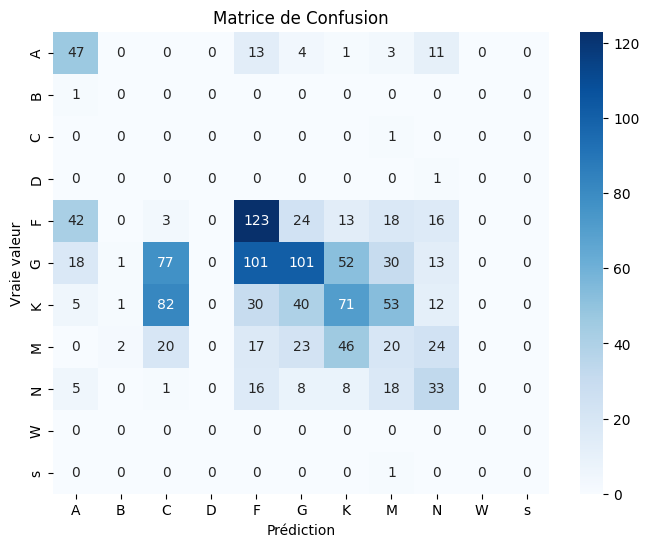

  > Modèle sauvegardé dans : c:\Users\alexb\Documents\Google_Cloud\alex_labs_google_sprint\astro_spectro_git\data\models\spectral_classifier.pkl


In [7]:
import pandas as pd
from pipeline.classifier import SpectralClassifier
import os

# 1) Charger ton dataset de features
features_df = pd.read_csv(
    os.path.join(PROCESSED_DIR, "features_20250722T184152Z.csv")  # adapte le nom du fichier au besoin
)

# 2) Nettoyer les lignes sans label valide (si présent)
features_df = features_df[features_df["label"].notnull() & (features_df["label"] != "UNKNOWN")]

# 3) Retirer les classes rares qui posent problème (moins de 2 échantillons)
label_counts = features_df["label"].value_counts()
rare_labels = label_counts[label_counts < 2].index
if len(rare_labels) > 0:
    print(f"Suppression des classes trop rares : {list(rare_labels)}")
    features_df = features_df[~features_df["label"].isin(rare_labels)]

# 4) Préparer X et y

# Identifier les colonnes non numériques (types object, excluant 'label')
non_numeric_cols = features_df.select_dtypes(include=["object"]).columns.tolist()

# S'assurer de retirer la colonne cible 'label' elle aussi des features
drop_cols = list(set(non_numeric_cols + ["label"]))

# Drop les colonnes inutiles
X = features_df.drop(columns=drop_cols).values

# Y comme vecteur cible
y = features_df["label"].values

print(f"\nFeatures utilisées pour l'entraînement : {features_df.drop(columns=drop_cols).columns.tolist()}")
print(f"Nombre d'échantillons : {X.shape[0]}, Nombre de features : {X.shape[1]}")

# 5) Créer et entraîner ton classifieur
clf = SpectralClassifier(n_estimators=200)
clf.train_and_evaluate(X, y, test_size=0.25)

# 6) Sauvegarder le modèle si satisfait
clf.save_model(os.path.join(MODELS_DIR, "spectral_classifier.pkl"))

**Permettre l'affichage des labels**

In [ ]:
print(features_df["label"].value_counts())

#

## 6) Mise à jour du journal des spectres utilisés et Génération du rapport de session 

Après la réussite de l’entraînement et la validation du pipeline, cette étape finalise le processus en ajoutant les spectres du lot courant au journal ``trained_spectra.csv``. Cela garantit qu’ils ne seront plus jamais resélectionnés dans de futurs lots.

Captures un résumé de ta session (timestamp, spectres, hash du modèle, métriques, etc.), ce qui vient figer l’état de ce traitement dans un rapport.

In [ ]:
if new_batch_paths:

    # Mise à jour du journal
    print("\n=== ÉTAPE 6: MISE À JOUR DU JOURNAL DES SPECTRES UTILISÉS ===")
    if not isinstance(new_batch_paths, list):
        raise ValueError("Le lot de spectres doit être une liste de chemins relatifs.")
    builder.update_trained_log(new_batch_paths)
    print("\n--- Session terminée. ---")


print("\n=== ÉTAPE 6 : GÉNÉRATION DU RAPPORT DE SESSION ===")

# Timestamp unique pour identifier la session
timestamp = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")

# Exemple : calcul d'un hash bidon du modèle, à remplacer par un vrai plus tard
# Par exemple, après classifier.save_model(path=...), tu pourrais lire le fichier et calculer son hash
dummy_model_hash = hashlib.md5(f"dummy_model_{timestamp}".encode()).hexdigest()

# Simule les métriques pour l'exemple (à remplacer par de vraies métriques calculées pendant l'entraînement)
metrics_summary = {
    "accuracy": 0.92,
    "f1_score": 0.89
}

BATCH_SIZE = 1000

# Crée le dictionnaire du rapport
session_report = {
    "timestamp": timestamp,
    "date": datetime.utcnow().isoformat() + "Z",
    "batch_size": BATCH_SIZE,
    "spectres_traites": len(new_batch_paths),
    "spectres_fichiers": new_batch_paths,
    "model_hash": dummy_model_hash,
    "metrics": metrics_summary
}

# Chemin de sauvegarde
report_filename = f"session_report_{timestamp}.json"
report_path = os.path.join("../reports", report_filename)

# Crée le dossier 'reports' s'il n'existe pas
os.makedirs("../reports", exist_ok=True)

# Sauvegarde le rapport
with open(report_path, "w") as f:
    json.dump(session_report, f, indent=4)

print(f"\nRapport de session sauvegardé dans : {report_path}")

#

#